In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/fer2013_clean.zip -d /content/dataset && echo "Dataset listo"

Dataset listo


In [ ]:
import os, glob
import numpy as np
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.cuda import amp

In [ ]:
# ========== DISPOSITIVO ==========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

# ========== MAPEO EMOCIONES ==========
emotion_to_index = {
    'angry': 0, 'disgust': 1, 'fear': 2,
    'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6
}

In [ ]:
# ========== DATASET ==========
class EmotionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for emotion in os.listdir(root_dir):
            emotion_dir = os.path.join(root_dir, emotion)
            if not os.path.isdir(emotion_dir): continue
            images = glob.glob(os.path.join(emotion_dir, '*.jpg'))
            self.image_paths.extend(images)
            self.labels.extend([emotion_to_index[emotion]] * len(images))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

In [ ]:
# ========== TRANSFORMACIONES ==========
# Augmentaciones para entrenamiento
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Transformaciones sin augmentación para validación y test
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
# ========== LOADERS ==========
def create_loader(dataset, batch_size=64, shuffle=True):
    return DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=min(4, os.cpu_count()), pin_memory=True, prefetch_factor=2
    )

train_dataset = EmotionDataset("/content/dataset/fer2013_editable/train", train_transform)
val_dataset = EmotionDataset("/content/dataset/fer2013_editable/val", test_transform)
test_dataset = EmotionDataset("/content/dataset/fer2013_editable/test", test_transform)

train_loader = create_loader(train_dataset)
val_loader = create_loader(val_dataset, shuffle=False)
test_loader = create_loader(test_dataset, shuffle=False)

In [ ]:
# ========== MODELO: EfficientNet-B2 ==========
from torchvision.models import efficientnet_b2

model = efficientnet_b2(pretrained=True)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 7)  # 7 clases
model = model.to(device)

# 🔥 Fine-tuning completo desde el principio
for param in model.features.parameters():
    param.requires_grad = True

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 162MB/s]


In [ ]:
# ========== PÉRDIDA Y OPTIMIZADOR ==========
all_labels = train_dataset.labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)
scaler = amp.GradScaler()

/tmp/ipython-input-9-1573709545.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


In [ ]:
# ========== FUNCIONES DE ENTRENAMIENTO ==========
def train_epoch(model, loader, criterion, optimizer, scheduler):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    scheduler.step()
    return total_loss / len(loader), correct / total

def validate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(loader), correct / total

In [ ]:
# ========== ENTRENAMIENTO ==========
def train_epoch(model, loader, criterion, optimizer, scheduler):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    scheduler.step()
    return total_loss / len(loader), correct / total

def validate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(loader), correct / total

In [ ]:
# ========== LOOP PRINCIPAL ==========
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

num_epochs = 150
best_val_loss = float('inf')
epochs_no_improve = 0
patience = 15  # ⏳ Aumentado para permitir mejor convergencia

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler)
    val_loss, val_acc = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_efficientnet_emotion.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("🛑 Early stopping activado.")
            break

    print(f"\nÉpoca {epoch+1}/{num_epochs} | LR: {scheduler.get_last_lr()[0]:.2e}")
    print(f"Entrenamiento: Pérdida {train_loss:.4f} - Precisión {train_acc:.4f} | Validación: Pérdida {val_loss:.4f} - Precisión {val_acc:.4f}")


Época 1/150 | LR: 1.98e-05
Entrenamiento: Pérdida 1.8248 - Precisión 0.2920 | Validación: Pérdida 1.5819 - Precisión 0.4619

Época 2/150 | LR: 1.91e-05
Entrenamiento: Pérdida 1.5404 - Precisión 0.4801 | Validación: Pérdida 1.3647 - Precisión 0.5501

Época 3/150 | LR: 1.81e-05
Entrenamiento: Pérdida 1.4117 - Precisión 0.5409 | Validación: Pérdida 1.2720 - Precisión 0.5999

Época 4/150 | LR: 1.67e-05
Entrenamiento: Pérdida 1.3384 - Precisión 0.5799 | Validación: Pérdida 1.2083 - Precisión 0.6342

Época 5/150 | LR: 1.50e-05
Entrenamiento: Pérdida 1.2864 - Precisión 0.6085 | Validación: Pérdida 1.1618 - Precisión 0.6622

Época 6/150 | LR: 1.31e-05
Entrenamiento: Pérdida 1.2513 - Precisión 0.6243 | Validación: Pérdida 1.1275 - Precisión 0.6817

Época 7/150 | LR: 1.10e-05
Entrenamiento: Pérdida 1.2237 - Precisión 0.6406 | Validación: Pérdida 1.1026 - Precisión 0.6911

Época 8/150 | LR: 8.95e-06
Entrenamiento: Pérdida 1.2014 - Precisión 0.6523 | Validación: Pérdida 1.0827 - Precisión 0.7014


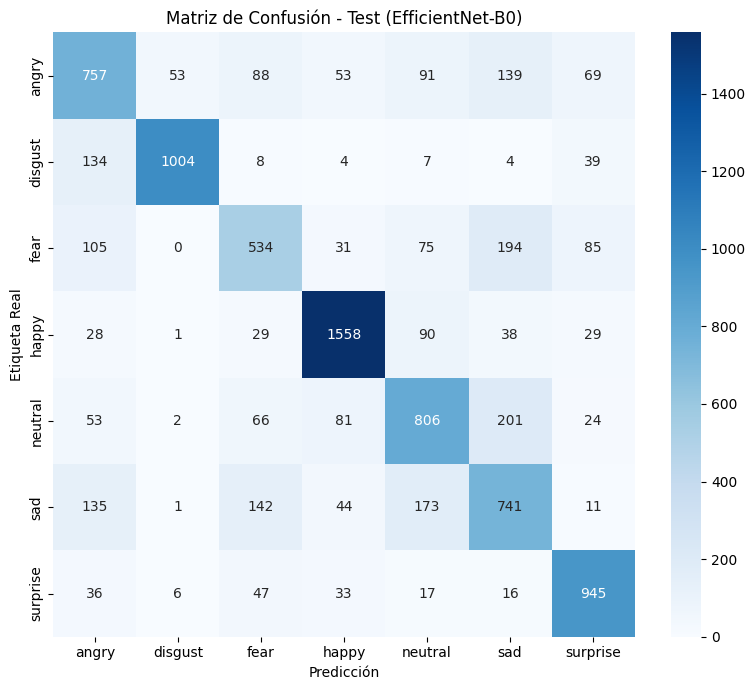

📊 Reporte de Clasificación:
              precision    recall  f1-score   support

       angry       0.61      0.61      0.61      1250
     disgust       0.94      0.84      0.89      1200
        fear       0.58      0.52      0.55      1024
       happy       0.86      0.88      0.87      1773
     neutral       0.64      0.65      0.65      1233
         sad       0.56      0.59      0.57      1247
    surprise       0.79      0.86      0.82      1100

    accuracy                           0.72      8827
   macro avg       0.71      0.71      0.71      8827
weighted avg       0.72      0.72      0.72      8827



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Asegúrate de tener el modelo en modo evaluación
model.load_state_dict(torch.load('best_efficientnet_emotion.pth'))
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Etiquetas
labels = list(emotion_to_index.keys())
cm = confusion_matrix(y_true, y_pred)

# Graficar matriz de confusión
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusión - Test (EfficientNet-B0)")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.tight_layout()
plt.show()

# Mostrar reporte detallado
print("📊 Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=labels))


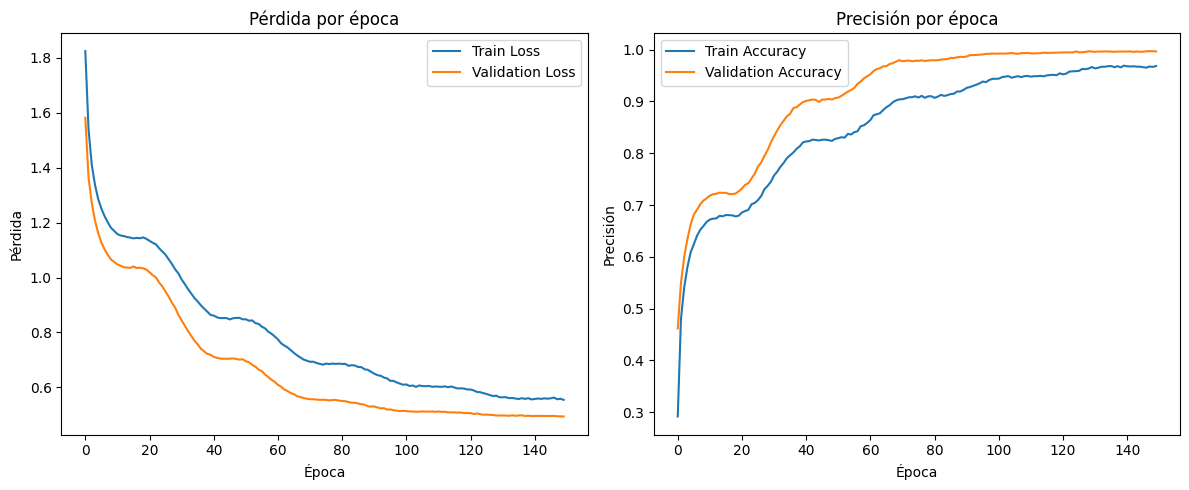

In [ ]:
# Graficar curvas de pérdida y precisión
plt.figure(figsize=(12, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida por época")
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.title("Precisión por época")
plt.legend()

plt.tight_layout()
plt.show()
